# Pascal VOC - Multi label classification

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [5]:
torch.backends.cudnn.benchmark = True

## Setup

**Globals**

In [15]:
print("categories json:", trn_j[CATEGORIES][0])
print("images json:", trn_j[IMAGES][0])
print("annotations json:", trn_j[ANNOTATIONS][0])

categories json: {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}
images json: {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}
annotations json: {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}


In [8]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [16]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [21]:
print(len(cats), len(trn_fns), len(trn_ids))

20 2501 2501


In [22]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH / JPEGS

In [23]:
IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [29]:
!ls {str(IMG_PATH)} | wc -l

5011


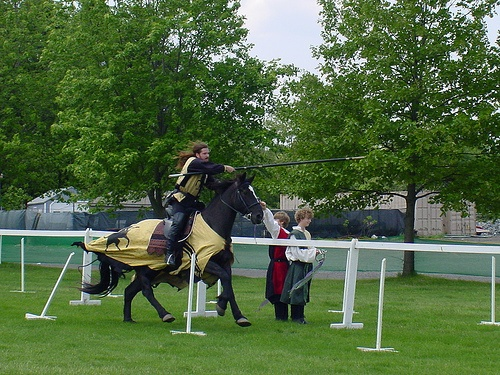

In [28]:
# DEBUG: try to show an image from the dataset in file system
from IPython.display import Image
Image(filename=str(IMG_PATH / '000009.jpg'))

**Define Common Functions**

Very similar to the first Pascal model (single object detection).

In [30]:
def hw_bb(bb):
    # Example, bb = [155, 96, 196, 174]
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

In [31]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])

    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX] # one bbox. looks like '[155, 96, 196, 174]'.
            bb = hw_bb(bb)
            trn_anno[o[IMG_ID]].append( (bb, o[CAT_ID]) )
    return trn_anno

In [42]:
trn_anno = get_trn_anno()
len(trn_anno)

2501

In [32]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [33]:
def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

In [34]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [35]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [36]:
def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

In [37]:
def draw_im(im, ann):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        # b is bbox, c is class id
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [38]:
def draw_idx(i):
    # i is image id
    im_a = trn_anno[i] # training annotations
    im = open_image(IMG_PATH / trn_fns[i]) # trn_fns is training image file names
    draw_im(im, im_a) # im_a is an element of annotation

## Multi class

**Setup**

In [39]:
MC_CSV = PATH / 'tmp/mc.csv'

In [43]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [44]:
mc = [ set( [cats[p[1]] for p in trn_anno[o] ] ) for o in trn_ids ]
mcs = [ ' '.join( str(p) for p in o ) for o in mc ] # stringify mc

In [51]:
print('mc:', mc[1])
print('mcs:', mcs[1])

mc: {'horse', 'person'}
mcs: horse person


In [52]:
df = pd.DataFrame({ 'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs }, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [54]:
# DEBUG: Check CSV file is created
!ls {str(PATH)}/tmp/

bb.csv	lrg.csv  mc.csv


In [55]:
# DEBUG: View CSV data
!head -n 10 {str(PATH)}/tmp/mc.csv

fn,clas
000012.jpg,car
000017.jpg,horse person
000023.jpg,person bicycle
000026.jpg,car
000032.jpg,person aeroplane
000033.jpg,aeroplane
000034.jpg,train
000035.jpg,person
000036.jpg,dog


### Model

Setup ResNet model and train.

In [57]:
f_model = resnet34
sz = 224
bs = 64

In [58]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [60]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [61]:
lrf = learn.lr_find(1e-5, 100)

epoch      trn_loss   val_loss   <lambda>                  
    0      1.705616   11.417138  0.5868    



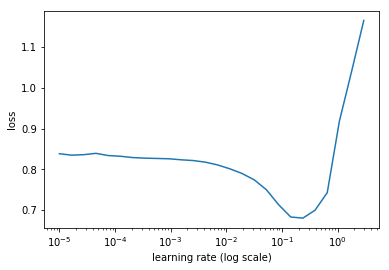

In [62]:
learn.sched.plot(0)

In [63]:
lr = 2e-2

In [64]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.319539   0.139347   0.9535    
    1      0.172275   0.080689   0.9724                    
    2      0.116136   0.075965   0.975                     



[array([0.07597]), 0.9750000004768371]

In [65]:
# Define learning rates to search
lrs = np.array([lr/100, lr/10, lr])

In [66]:
# Freeze the model till the last 2 layers as before
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s, loss=0.464] 

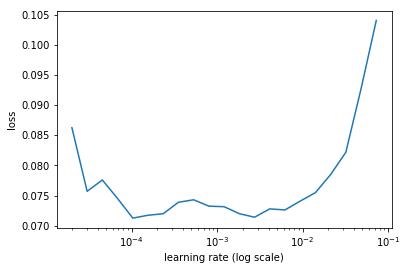

In [67]:
# Find the optimal learning rate again
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [68]:
# Refit the model
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.071997   0.078266   0.9734    
    1      0.055321   0.082668   0.9737                     
    2      0.040407   0.077682   0.9757                     
    3      0.027939   0.07651    0.9756                     
    4      0.019983   0.07676    0.9763                     


[array([0.07676]), 0.9763000016212463]

Save the model

In [69]:
learn.save('mclas')

In [70]:
learn.load('mclas')

### Evaluate

In [71]:
y = learn.predict()
x, _ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


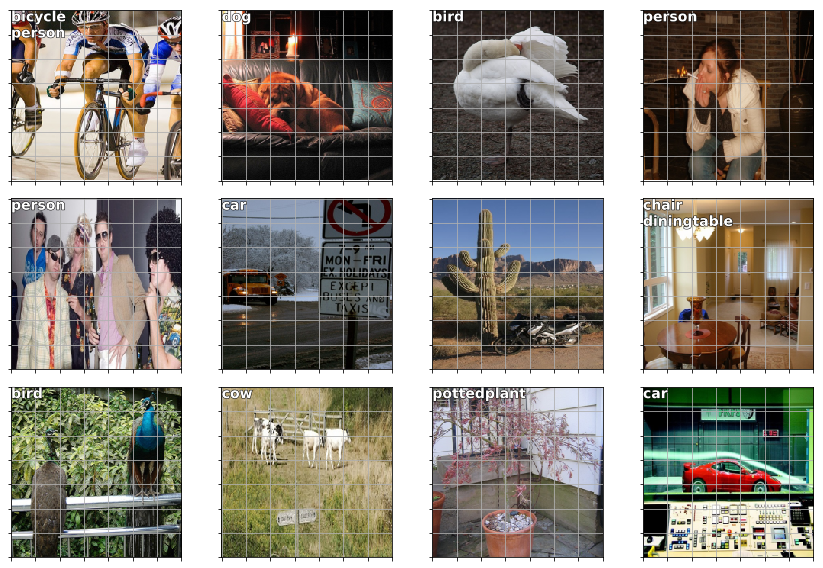

In [72]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()

## Multiple bounding box (bbox) per cell

### Set up data

In [74]:
CLAS_CSV = PATH / 'tmp/clas.csv'
MBB_CSV = PATH / 'tmp/mbb.csv'

f_model = resnet34
sz = 224
bs = 64

Create lookups and reference objects.

- `mc` - list of items found per image.
- `mcs` - list of items found per image, but the ID.
- `id2cat` - numeric value to category.
- `cat2id` - category to id.

In [75]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]

In [101]:
# DEBUG: inspect mc variable
mc[4]

['aeroplane', 'aeroplane', 'person', 'person']

In [86]:
id2cat = list(cats.values())

In [93]:
cat2id = { v: k for k, v in enumerate(id2cat) }

In [102]:
mcs = np.array([ np.array([ cat2id[p] for p in o ]) for o in mc ])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [97]:
# DEBUG: inspect cats variable
cats[4], id2cat[3], cat2id['boat']

('boat', 'boat', 3)

In [104]:
# Get cross validation ids
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs), ) = split_by_idx(val_idxs, mcs)

Create and save multiple bounding boxes.

In [131]:
mbb = [ np.concatenate( [ p[0] for p in trn_anno[o] ] ) for o in trn_ids]

In [129]:
# DEBUG: inspect trn_anno dict
trn_anno[12][0]

(array([ 96, 155, 269, 350]), 7)

In [141]:
mbb[12].shape, mbb[12]

((8,), array([106,  57, 464, 290,   0,   1, 499, 301]))

In [142]:
mbbs = [ ' '.join( str(p) for p in o ) for o in mbb ]

In [143]:
mbbs[12]

'106 57 464 290 0 1 499 301'

In [144]:
df = pd.DataFrame({ 'fn': [ trn_fns[o] for o in trn_ids ], 'bbox': mbbs }, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [146]:
# DEBUG: check CSV file is created in file system
!ls {PATH}/tmp

bb.csv	lrg.csv  mbb.csv  mc.csv


In [147]:
# DEBUG: view CSV data
!head -n 10 {PATH / 'tmp/mbb.csv'}

fn,bbox
000012.jpg,96 155 269 350
000017.jpg,61 184 198 278 77 89 335 402
000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 461 242 0 224 485 333
000026.jpg,124 89 211 336
000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 188 25 237 43
000033.jpg,106 8 262 498 199 420 225 481 187 324 222 410
000034.jpg,166 115 399 359 152 140 228 332
000035.jpg,95 0 360 190 97 217 317 464
000036.jpg,78 26 343 318


In [148]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

Setup dataset.

In [149]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

### Setup some plotting functions

In [150]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

In [151]:
def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [152]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [185]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1, 4)]
    if prs is None:
        prs = [None] * len(bb)
    if clas is None:
        clas = [None] * len(bb)
    
    ax = show_img(im, ax=ax)
    
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
#         print('=============================')
#         print(f'b: {b}')
#         print(f'c: {c}')
#         print(f'pr: {pr}')
        if((b[2] > 0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i % num_colr])
            txt = f'{i} '
#             print('txt:', txt)
            if c is not None:
                txt += ('bg' if c == 0 else id2cat[c]) # previously, c == len(id2cat)
#                 print('c txt:', txt)
            if pr is not None:
                txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i % num_colr])

In [182]:
id2cat[0], id2cat[1], id2cat[12], id2cat[13], id2cat[19]

('aeroplane', 'bicycle', 'horse', 'motorbike', 'tvmonitor')

### Create dataset with 2 associated labels.

In [154]:
class ConcatLblDataset(Dataset):
    """
    A dataset that adds a second label to an existing dataset.
    """

    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [155]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

### View the sample labels

For validation dataset

In [162]:
x, y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


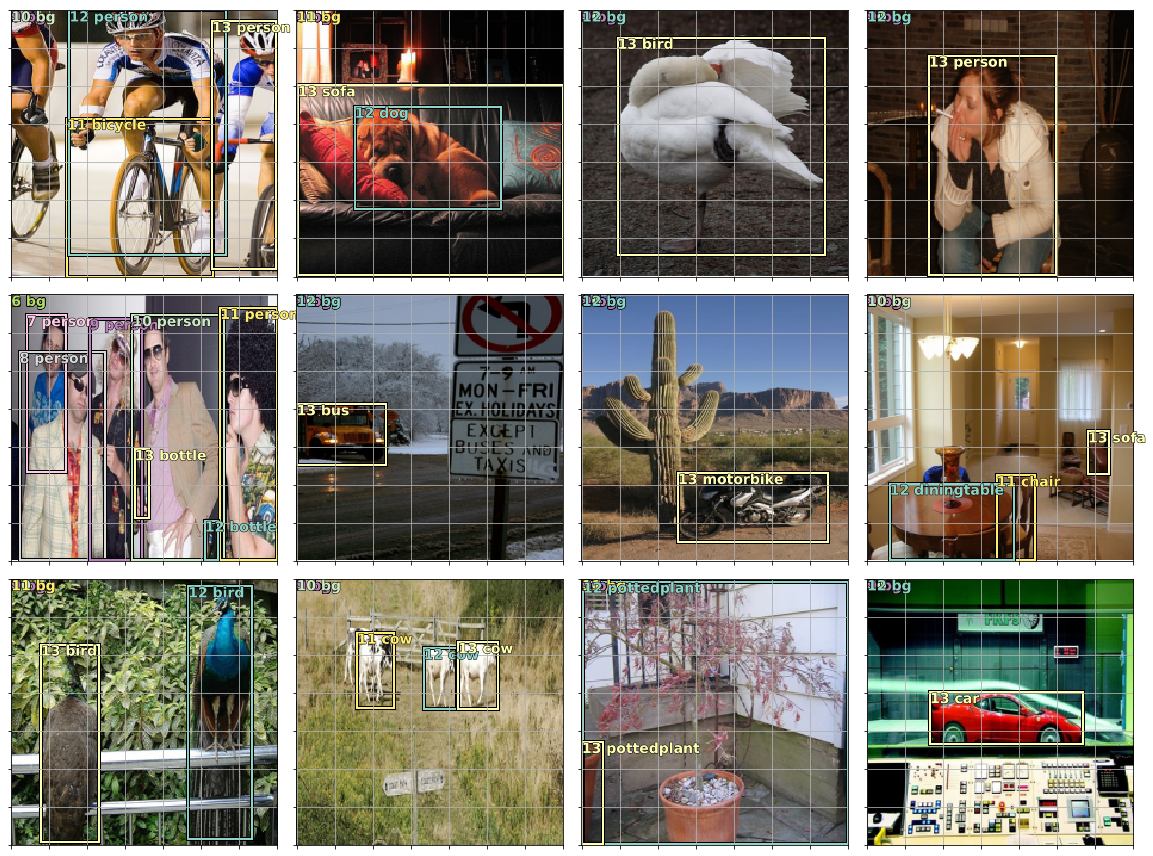

In [186]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

For training dataset

In [187]:
x, y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

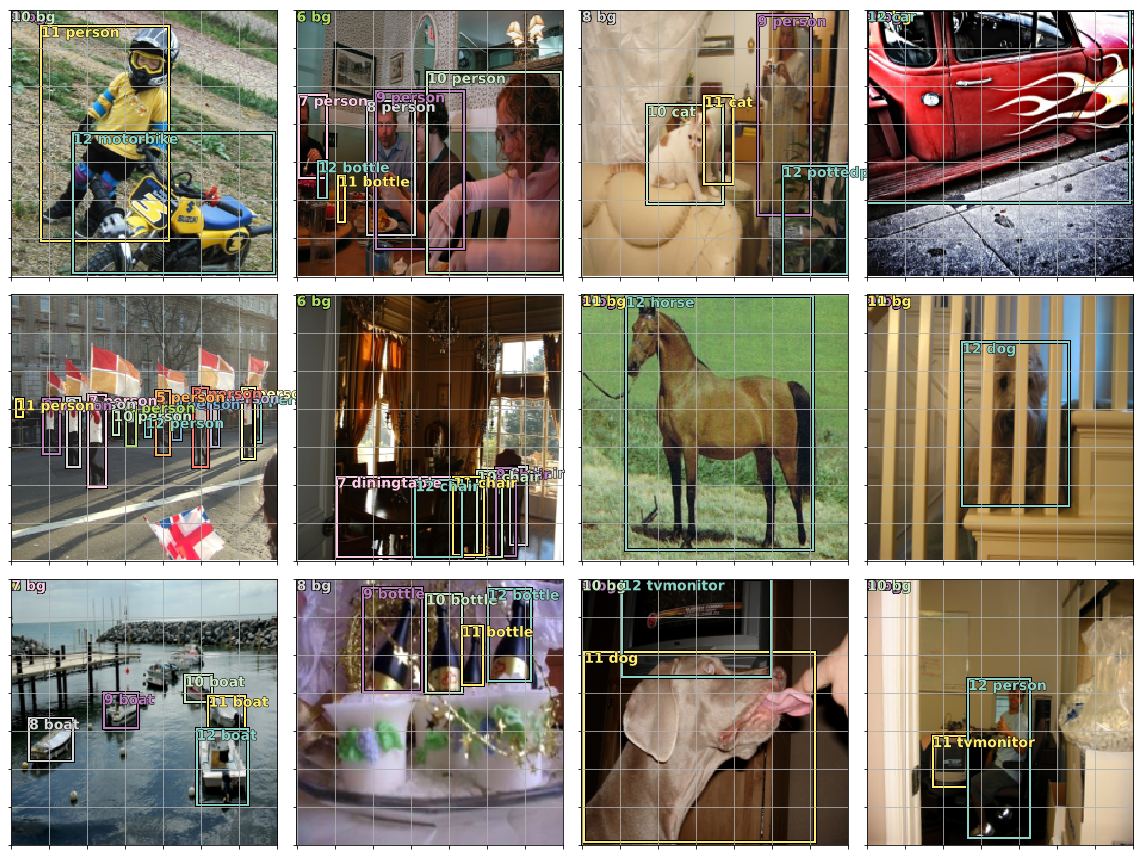

In [188]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Make a model to predict what shows up in a 4x4 grid

### Set up model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

Anchor Grid

- `anc_grid`: how big of a square grid to make (subdivision)
- `anc_offset`: center offsets
- `anc_x`: x coordinates for centers
- `anc_y`: y coordinates for centers
- `anc_ctrs`: the actual coordinates for the grid centers
- `anc_sizes`: size of the quadrants

In [222]:
anc_grid = 4
k = 1

anc_offset = 1 / (anc_grid * 2)
anc_x = np.repeat(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1))
anc_sizes = np.array([ [ 1 / anc_grid, 1 / anc_grid ] for i in range(anc_grid * anc_grid) ])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float() # convert LongTensor to FloatTensor

_Note to self: difference between numpy concatenate and stack_
- _numpy concatenate join a sequence of arrays along an **existing axis**._
- _numpy stack join a sequence of arrays along a **new axis**._

In [214]:
# ================= DEBUG =================
# np.concatenate([anc_ctrs, anc_sizes], axis=1)
anc_ctrs = np.array([[1, 2], [3, 4]]) # example of 2 center points
anc_sizes = np.array([[5], [6]]) # example of size for each point

# print(arr_two.T)
concat_ctrs_sz = np.concatenate([anc_ctrs, anc_sizes], axis=1)
print(concat_ctrs_sz)
print('')
print(V(concat_ctrs_sz, requires_grad=False).float())

# np.stack([anc_x, anc_y], axis=1)
anc_x = np.array([1, 2, 3])
anc_y = np.array([2, 3, 4])
stack_x_y = np.stack([anc_x, anc_y], axis=1)
print(stack_x_y)
# ================= END DEBUG =================

[[1 2 5]
 [3 4 6]]

Variable containing:
 1  2  5
 3  4  6
[torch.cuda.FloatTensor of size 2x3 (GPU 0)]

[[1 2]
 [2 3]
 [3 4]]


In [223]:
# unsqueeze is like TF add_dims, add dimension to a tensor.
# from tensor size 1 to size 1x1
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0, 1)

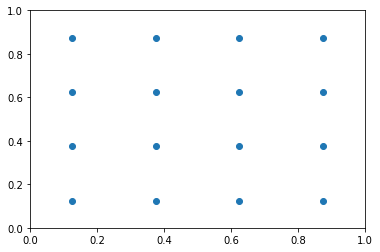

In [224]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [225]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [226]:
def hw2corners(ctr, hw):
    return torch.cat([ctr - hw / 2, ctr + hw / 2], dim=1)

In [ ]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

In [229]:
# anchors[:, :2] # first 2 columns (which is where the center coords are)
# anchors[:, 2:] # all columns after the second one (which is where the height & width are)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [ ]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [233]:
n_clas = len(id2cat) + 1 # plus 1 for the background (bg) class
n_act = k * (4 + n_clas) # 1 * (4 + 21)
n_act

25

### Build a simple convolutional model

In [241]:
class StdConv(nn.Module):
    """
    A combination block of Conv2d, BatchNorm, Dropout
    """
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

In [242]:
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf//k)

This is an output convolutional model with 2 `Conv2d` layers.

In [246]:
class OutConv(nn.Module):
    """
    A combination block of `Conv2d`, `4 x Stride 1`, `Conv2d`, `C x Stride 1` with two layers.
    
    We are outputting `4 + C`
    """
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1) * k, 3, padding=1) # +1 is adding one more class for background.
        self.oconv2 = nn.Conv2d(nin, 4 * k, 3, padding=1)
        self.oconv1.bias.data.zero_().add(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

## The SSD Model

In [244]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        # Stride 1 conv doesn't change the dimension size, but we have a mini neural network
        self.sconv0 = StdConv(512, 256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [247]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### Train

How do we write a loss function for this?

- Has to look at each of these **16 sets** of activations, which will each have **4 bounding box** and **categories + 1**.
- The loss function actually needs to take each object in the image and match them to a convolutional grid cell. This is called the **matching problem**.

In [253]:
# DEBUG: torch.eye

torch.eye(5)


 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0
 0  0  0  1  0
 0  0  0  0  1
[torch.FloatTensor of size 5x5]

In [254]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

In [256]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, pred, targ):
        t = one_hot_embedding(targ,self.num_classes + 1)
        t = V(t[:, :-1].contiguous())#.cpu()
        x = pred[:, :-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self, x, t):
        return None

In [257]:
loss_f = BCE_Loss(len(id2cat))

**Matching Problem**

In [258]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [259]:
def box_sz(b):
    return ( (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]) )


In [260]:
def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [261]:
def get_y(bbox, clas):
    bbox = bbox.view(-1, 4) / sz
    bb_keep = ( (bbox[:, 2] - bbox[:, 0]) > 0 ).nonzero()[:, 0]
    return bbox[bb_keep], clas[bb_keep]

In [262]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:, :2] / 2 * grid_sizes) + anchors[:, :2]
    actn_hw = (actn_bbs[:, 2:] / 2 + 1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

In [263]:
def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it:
        print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i, o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap, gt_idx

In [264]:
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:, 0]
    gt_clas[1 - pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ( (a_ic[pos_idx] - gt_bbox[pos_idx]).abs() ).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [265]:
def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it:
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls + lcs

Testing

In [ ]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [266]:
x, y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x, y = V(x), V(y)

In [267]:
for i, o in enumerate(y):
    y[i] = o.cpu()
learn.model.cpu()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [268]:
batch = learn.model(x)

RuntimeError: Input type (CUDAFloatTensor) and weight type (CPUFloatTensor) should be the same